<a href="https://colab.research.google.com/github/ravirajdasari/deeplearning/blob/master/CatVsDogClassifier_using_TransferLearning_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
import json
!mkdir .kaggle

#Enter kaggle api credentials
token = {"username":<user> ,"key":<apitoken>}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}


In [ ]:
!kaggle datasets list -s 'cats'

ref                                                        title                                                size  lastUpdated          downloadCount  
---------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
chetankv/dogs-cats-images                                  Dogs & Cats Images                                  435MB  2018-04-19 18:20:08          12436  
mmoreaux/audio-cats-and-dogs                               Audio Cats and Dogs                                  97MB  2017-10-05 09:40:26           5040  
biaiscience/dogs-vs-cats                                   Dogs vs Cats                                        817MB  2017-12-05 14:03:33           6073  
tongpython/cat-and-dog                                     Cat and Dog                                         218MB  2018-04-26 10:56:50          22835  
crawford/cat-dataset                                       Cat Dataset

In [ ]:
!kaggle datasets download -d chetankv/dogs-cats-images -p /content --force
!unzip dogs-cats-images.zip

 97% 420M/435M [00:05<00:00, 66.9MB/s]
100% 435M/435M [00:05<00:00, 80.9MB/s]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%load_ext tensorboard

# Helper libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime

print(tf.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.3.0


In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 -O inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-09-02 06:06:33--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M   128MB/s    in 0.7s    

2020-09-02 06:06:34 (128 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
weights1="inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(weights1)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_18[0][0]                   
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [ ]:
last_output = pre_trained_model.layers[-1].output

In [ ]:
last_output

<tf.Tensor 'mixed10/concat_2:0' shape=(None, 5, 5, 2048) dtype=float32>

In [ ]:
x = Flatten()(last_output)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)                  
x = Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = Adam(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
model

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory("dataset/training_set/",
                                                    batch_size = 32,
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory("dataset/test_set/",
                                                    batch_size = 32,
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224))      

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 10,
            validation_steps = 50,
            verbose = 2)

Epoch 1/10
100/100 - 48s - loss: 0.5890 - accuracy: 0.9150 - val_loss: 0.0420 - val_accuracy: 0.9856
Epoch 2/10
100/100 - 46s - loss: 0.0885 - accuracy: 0.9675 - val_loss: 0.0401 - val_accuracy: 0.9862
Epoch 3/10
100/100 - 47s - loss: 0.0860 - accuracy: 0.9663 - val_loss: 0.0449 - val_accuracy: 0.9844
Epoch 4/10
100/100 - 46s - loss: 0.0793 - accuracy: 0.9709 - val_loss: 0.0359 - val_accuracy: 0.9887
Epoch 5/10
100/100 - 46s - loss: 0.0982 - accuracy: 0.9613 - val_loss: 0.0414 - val_accuracy: 0.9887
Epoch 6/10
100/100 - 47s - loss: 0.0660 - accuracy: 0.9741 - val_loss: 0.0249 - val_accuracy: 0.9881
Epoch 7/10
100/100 - 47s - loss: 0.0842 - accuracy: 0.9691 - val_loss: 0.0305 - val_accuracy: 0.9900
Epoch 8/10
100/100 - 46s - loss: 0.0813 - accuracy: 0.9691 - val_loss: 0.0319 - val_accuracy: 0.9887
Epoch 9/10
100/100 - 46s - loss: 0.0725 - accuracy: 0.9712 - val_loss: 0.0374 - val_accuracy: 0.9881
Epoch 10/10
100/100 - 46s - loss: 0.0619 - accuracy: 0.9762 - val_loss: 0.0519 - val_accura

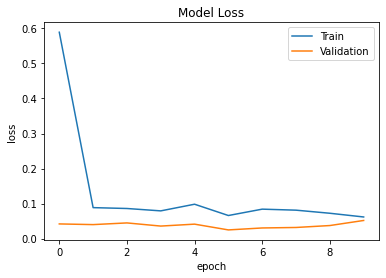

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)

print('\nTest accuracy:', test_acc)

63/63 - 8s - loss: 0.0461 - accuracy: 0.9850

Test accuracy: 0.9850000143051147
